### Can we classify each phase as relatively low or high anxiety for each subject? ###

In [18]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_apd as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)

temp_a, _ = train.Train_APD.get_apd_data_ranking([train.Metrics.BPM], phases=dr.Phases.PHASES_LIST, normalize=False)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_apd_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_apd_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))

In [26]:
models = {
    # "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000, solver="liblinear"),
    # "Bayes": GaussianNB(),
    "RF": RandomForestClassifier(n_estimators=100, max_features=3),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="error")
}

y_train | y_test:
{0: 187, 1: 137} | {0: 45, 1: 36}
y_train | y_test:
{0: 182, 1: 142} | {0: 50, 1: 31}
y_train | y_test:
{0: 186, 1: 138} | {0: 46, 1: 35}
y_train | y_test:
{0: 186, 1: 138} | {0: 46, 1: 35}
y_train | y_test:
{0: 187, 1: 137} | {0: 45, 1: 36}
Fold #0
Model LogReg, Predictions: [0 1], [80  1]


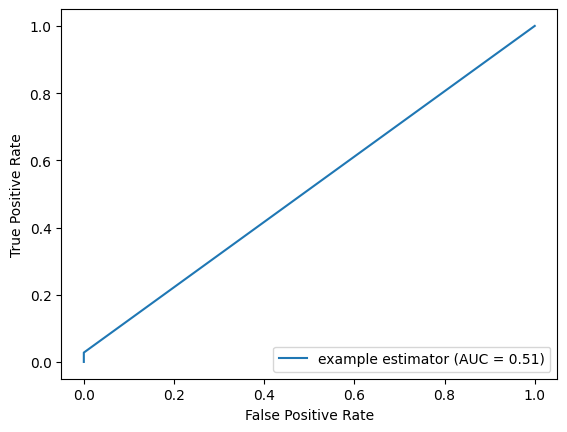

Fold #1
Model LogReg, Predictions: [0 1], [80  1]


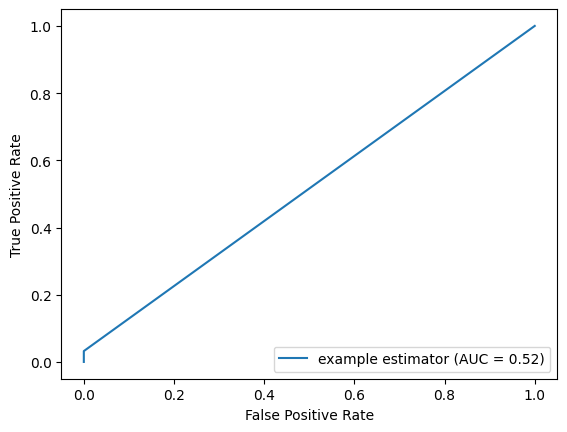

Fold #2
Model LogReg, Predictions: [0 1], [79  2]


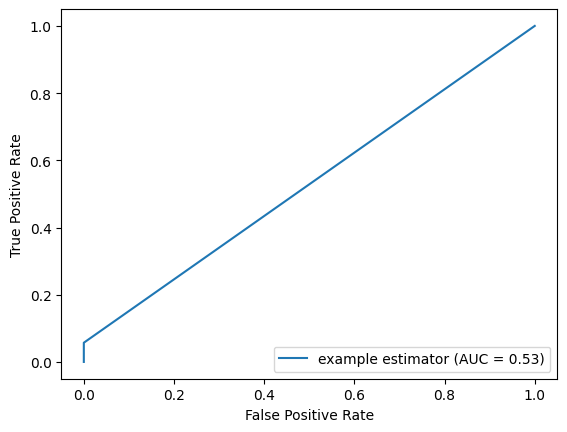

Fold #3
Model LogReg, Predictions: [0 1], [80  1]


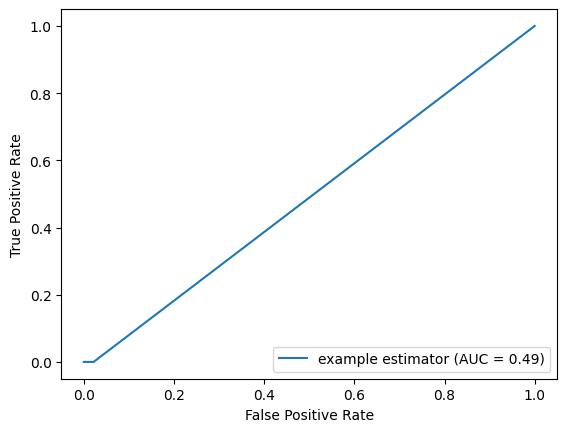

Fold #4
Model LogReg, Predictions: [0 1], [79  2]


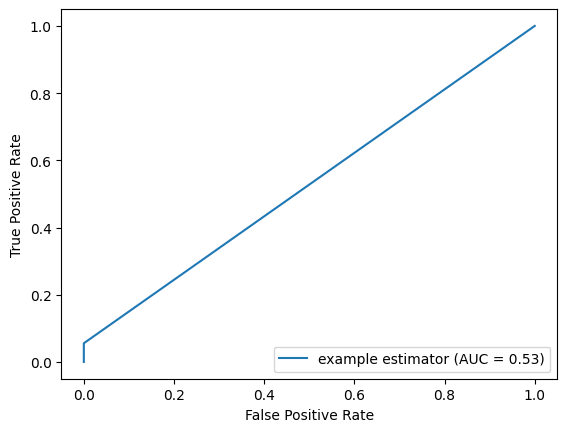

Fold #0
Model RF, Predictions: [0 1], [45 36]


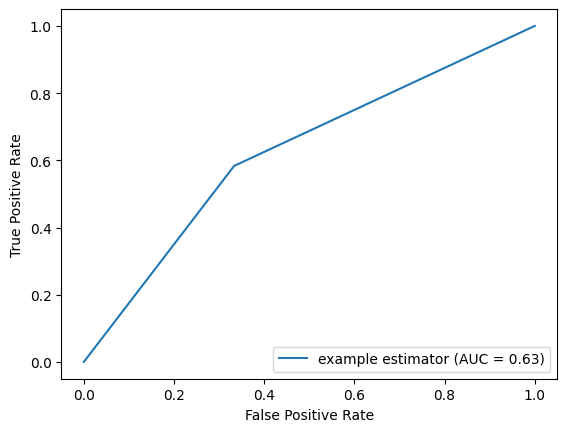

Fold #1
Model RF, Predictions: [0 1], [59 22]


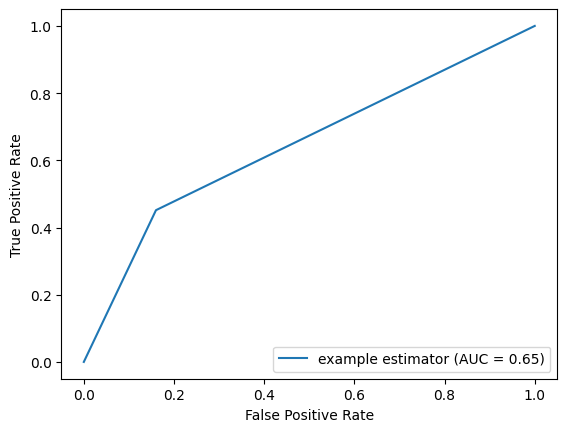

Fold #2
Model RF, Predictions: [0 1], [46 35]


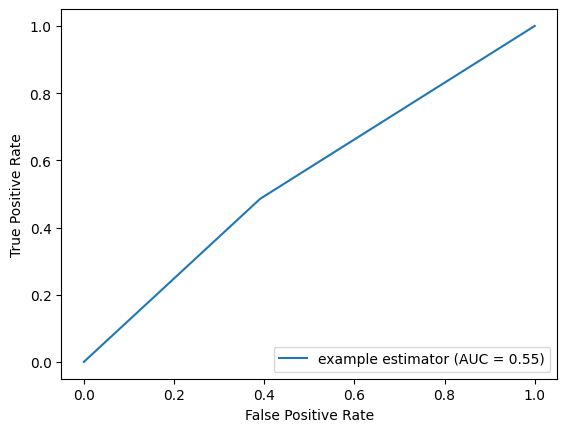

Fold #3
Model RF, Predictions: [0 1], [62 19]


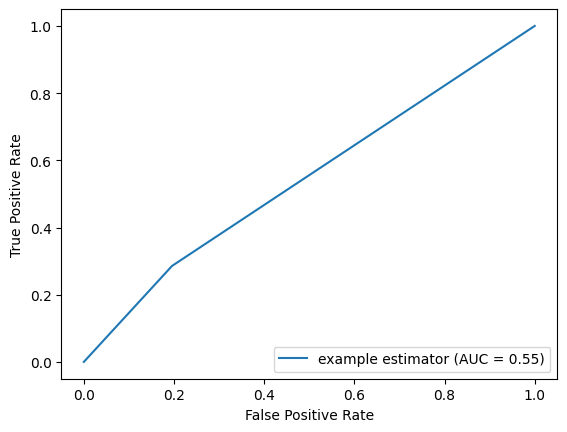

Fold #4
Model RF, Predictions: [0 1], [54 27]


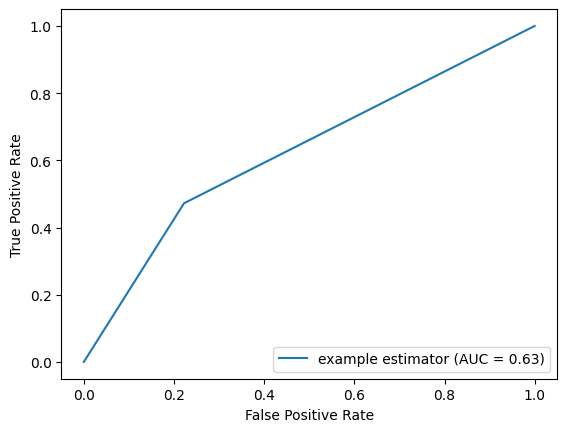

Fold #0
Model XGB, Predictions: [0 1], [39 42]


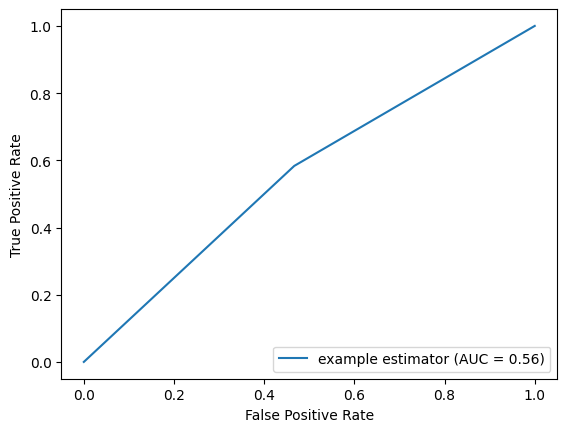

Fold #1
Model XGB, Predictions: [0 1], [57 24]


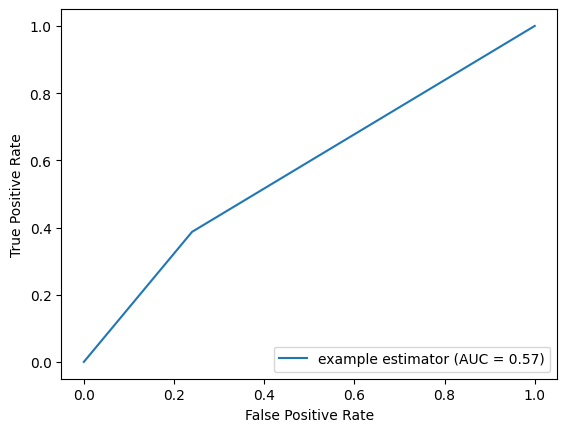

Fold #2
Model XGB, Predictions: [0 1], [42 39]


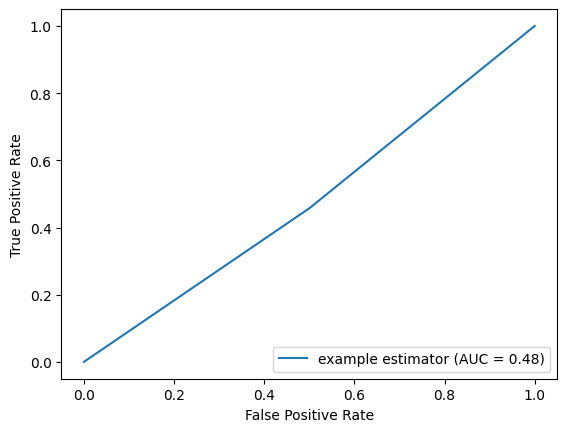

Fold #3
Model XGB, Predictions: [0 1], [59 22]


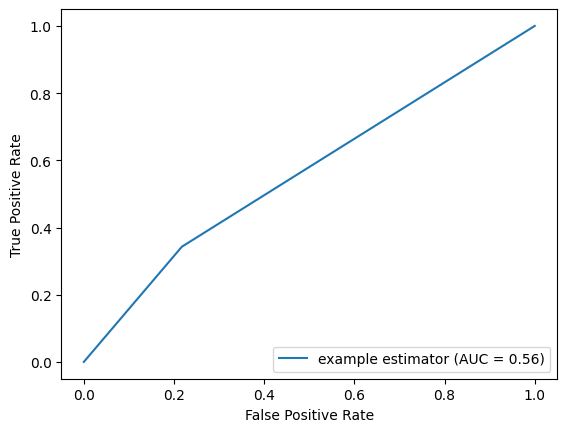

Fold #4
Model XGB, Predictions: [0 1], [57 24]


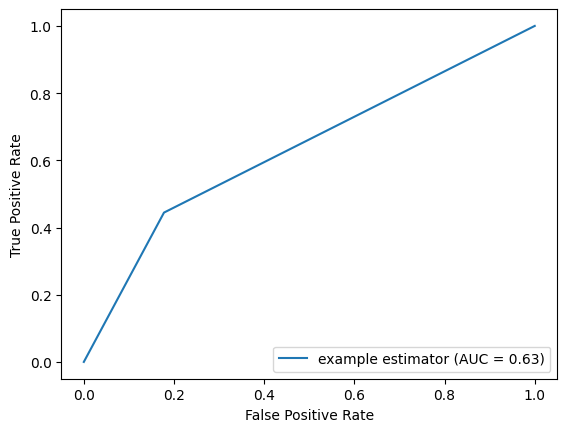


[('lf_hf_ratio', 1.2325907508493252), ('mean_SCL', 0.9118558313217813), ('lf_rr', 0.8391192734531849), ('hf_rr', 0.8314919990505416), ('sdnn', 0.100205465315244), ('rmssd', 0.01499575408369153), ('bpm', 0.00923004627173231), ('SCR_rate', -1.0429268803536147)]
[('lf_hf_ratio', 1.6008716756776658), ('mean_SCL', 1.2634847669226494), ('lf_rr', 1.0920191648986342), ('hf_rr', 0.9253647338372915), ('sdnn', 0.3964691504679666), ('bpm', 0.34300371555538717), ('rmssd', -0.3441482607529499), ('SCR_rate', -1.1546901291649538)]
[('lf_hf_ratio', 1.7281494686163552), ('mean_SCL', 1.2393665045973683), ('lf_rr', 1.107966686676331), ('hf_rr', 1.08192872839309), ('bpm', 0.7415407511315493), ('sdnn', 0.34794861048147463), ('rmssd', 0.05258099290305753), ('SCR_rate', -0.749954760933195)]
[('lf_hf_ratio', 1.6257502872983303), ('lf_rr', 1.5727038293984072), ('mean_SCL', 1.2634736720398267), ('hf_rr', 1.1337878197247526), ('bpm', 0.2947929149652578), ('sdnn', 0.2478026025543369), ('rmssd', -0.456049210018167

In [27]:
# LOAD TRAIN AND TEST DATA
importlib.reload(train)
importlib.reload(dr)
importlib.reload(dt)


metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    # train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE, 
]

model_phases = [
    "Baseline_Rest", 
    "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
    "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
]

threshold = "fixed"

anxiety_label_type = None
x, y = train.Train_APD.get_apd_data_ranking(metrics, model_phases, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
x = x.drop(["phaseId"], axis=1)

# drop subjects with noisy data
x = x[~x["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y = y[~y["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)

if anxiety_label_type is not None:
    x.drop(labels=["anxietyGroup"], axis=1)
    
acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_importance = True
for _ in range(num_iters):
    out = train.train_predict(models, x, y, by_subject=True, save_metrics=True, is_resample=True, get_importance=get_importance, drop_subject=True, test_size=0.2, folds=5)
    for model_name in acc_results:
        for i in range(len(out[model_name])):
            acc_results[model_name].append(out[model_name][i][0])
            reports[model_name].append(out[model_name][i][1])
        if get_importance:
            try:
                print("")
                # shap.plots.bar(out[model_name][0][2])
                for i in range(len(out[model_name])):
                    feature_imp = list(zip(metrics + ["lf_hf_ratio"], out[model_name][i][2]))
                    feature_imp = sorted(feature_imp, key=lambda x: x[1], reverse=True)
                    print(feature_imp)
            except Exception as e:
                print(out[model_name][0][2])
            print("")

for model_name in acc_results.keys():
    if acc > 0.5:
        print(f"Model evaluation metrics for {model_name}:")
        for i in range(len(reports[model_name])):
            report = reports[model_name][i]
            acc = acc_results[model_name][i]
            p = report["precision"]
            r = report["recall"]
            f1 = report["f1"]
            auc = report["auc"]
            print(f"\tAccuracy: {acc}\n\tPrecision: {p}\n\tRecall: {r}\n\tF1-score: {f1}\n\tAUC score: {auc}\n" + "-"*40)
    print("")
print("\n")

In [ ]:
# LOAD TRAIN AND TEST DATA -- train on some phases and test on others
importlib.reload(train)
importlib.reload(dr)
importlib.reload(dt)

# metrics = train.Metrics.ALL
# metrics = train.Metrics.ECG \
    # + train.Metrics.EDA \
    # + train.Metrics.ANKLE + train.Metrics.WRIST

metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    # train.Metrics.HF_RR, 
    # train.Metrics.LF_RR, 
    train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE, 
]

phases_a = [
    "Baseline_Rest", 
    "BugBox_Relax", 
    "BugBox_Anticipate", 
    # "BugBox_Exposure", 
    # "BugBox_Break",
    "Speech_Relax", 
    "Speech_Anticipate", 
    # "Speech_Exposure", 
    # "Speech_Break"
]

phases_b = [
    # "Baseline_Rest", 
    # "BugBox_Relax", 
    # "BugBox_Anticipate", 
    "BugBox_Exposure", 
    # "BugBox_Break",
    # "Speech_Relax", 
    # "Speech_Anticipate", 
    "Speech_Exposure", 
    # "Speech_Break"
]

models = {
    "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

anxiety_label_type = "Anxiety"
# anxiety_label_type = None
test_size = 1.0

x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, phases_a, verbose=False, anxiety_label_type=anxiety_label_type)
x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_b, verbose=False, anxiety_label_type=anxiety_label_type)
x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# drop subjects with noisy data

x_a = x_a[~x_a["subject"].isin(invalid_apd_subjects)]
y_a = y_a[~y_a["subject"].isin(invalid_apd_subjects)]
x_b = x_b[~x_b["subject"].isin(invalid_apd_subjects)]
y_b = y_b[~y_b["subject"].isin(invalid_apd_subjects)]

print(f"y_a:\n{y_a.loc[:, 'label'].value_counts()}")
print(f"y_b:\n{y_b.loc[:, 'label'].value_counts()}")

# x = x[x['subject'] != 8.0]
# y = y[y['subject'] != 8.0]

if anxiety_label_type is not None:
    x_a.drop(labels=["anxietyGroup"], axis=1)
    x_b.drop(labels=["anxietyGroup"], axis=1)

# 0-1 scaling
for i in range(3, len(x_a.columns)):
    data_col = x_a[x_a.columns[i]]
    data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
    x_a[x_a.columns[i]] = data_col
for i in range(3, len(x_b.columns)):
    data_col = x_b[x_b.columns[i]]
    data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
    x_b[x_b.columns[i]] = data_col
    
# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500

acc_results = {
    "SVM": [],
    "LogReg": [],
    "XGB": []
}
reports = {
    "SVM": [],
    "LogReg": [],
    "XGB": []
}
num_iters = 10
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.4:
        print(f"Model evaluation metrics for {model_name}:")
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
    print("")
print("\n")